In [165]:
import io

import numpy as np
import pandas as pd
import functools as ft
import tensorflow as tf

import plotly.plotly as py
import plotly.graph_objs as go

import scipy.ndimage as nd
import matplotlib.pyplot as plt

from tensorflow.python.summary.event_multiplexer import EventMultiplexer

In [128]:
def build_runs(names, path, rounds):
    return {k: d[k] for d in [{'{}{}'.format(s, i): path.format(s, i) for i in range(1, rounds+1)} for s in names] for k in d}

runs_th30 = build_runs(['test', 'train'], '/tmp/mrtous/{}/th30-ep30/{}', 4)

emp_th30 = EventMultiplexer(runs_th30)
emp_th30.Reload()

print('')

INFO:tensorflow:Event Multiplexer initializing.
INFO:tensorflow:Event Multplexer doing initialization load for {'test2': '/tmp/mrtous/test/th30-ep30/2', 'test1': '/tmp/mrtous/test/th30-ep30/1', 'train3': '/tmp/mrtous/train/th30-ep30/3', 'test4': '/tmp/mrtous/test/th30-ep30/4', 'train1': '/tmp/mrtous/train/th30-ep30/1', 'train4': '/tmp/mrtous/train/th30-ep30/4', 'test3': '/tmp/mrtous/test/th30-ep30/3', 'train2': '/tmp/mrtous/train/th30-ep30/2'}
INFO:tensorflow:Constructing EventAccumulator for /tmp/mrtous/test/th30-ep30/2
INFO:tensorflow:Constructing EventAccumulator for /tmp/mrtous/test/th30-ep30/1
INFO:tensorflow:Constructing EventAccumulator for /tmp/mrtous/train/th30-ep30/3
INFO:tensorflow:Constructing EventAccumulator for /tmp/mrtous/test/th30-ep30/4
INFO:tensorflow:Constructing EventAccumulator for /tmp/mrtous/train/th30-ep30/1
INFO:tensorflow:Constructing EventAccumulator for /tmp/mrtous/train/th30-ep30/4
INFO:tensorflow:Constructing EventAccumulator for /tmp/mrtous/test/th30-ep3

In [125]:
def extract_loss(emp, runs):
    loss = {r: list(zip(*map(lambda s: (s.step, s.value), evmp.Scalars(r, 'loss/loss')))) for r in runs.keys()}
    
    return pd.DataFrame({r: pd.Series(loss[r][1], name=r, index=loss[r][0]) for r in runs.keys()})

In [129]:
df_th30 = extract_loss(emp_th30, runs_th30)

test_th30 = df[['test1', 'test2', 'test3', 'test4']].dropna()
train_th30 = df[['train1', 'train2', 'train3', 'train4']]

layout = go.Layout(xaxis=dict(title='step'), yaxis=dict(title='norm'))

test_th30_data = [go.Scatter(name=c, x=test.index, y=test_th30[c]) for c in test_th30.columns]
train_th30_data = [go.Scatter(name=c, x=test.index, y=train_th30[c]) for c in train_th30.columns]

In [130]:
py.iplot(go.Figure(data=test_th30_data, layout=layout))

In [131]:
py.iplot(go.Figure(data=train_th30_data, layout=layout))

In [132]:
runs_th10 = build_runs(['train'], '/tmp/mrtous/{}/th10-ep30/{}', 2)

emp_th10 = EventMultiplexer(runs_th10)
emp_th10.Reload()

print('')

INFO:tensorflow:Event Multiplexer initializing.
INFO:tensorflow:Event Multplexer doing initialization load for {'train1': '/tmp/mrtous/train/th10-ep30/1', 'train2': '/tmp/mrtous/train/th10-ep30/2'}
INFO:tensorflow:Constructing EventAccumulator for /tmp/mrtous/train/th10-ep30/1
INFO:tensorflow:Constructing EventAccumulator for /tmp/mrtous/train/th10-ep30/2
INFO:tensorflow:Event Multiplexer done initializing
INFO:tensorflow:Beginning EventMultiplexer.Reload()
INFO:tensorflow:No path found after /tmp/mrtous/train/th10-ep30/1/events.out.tfevents.1482129136.Bodos-MacBook-Pro.local
INFO:tensorflow:No path found after /tmp/mrtous/train/th10-ep30/2/events.out.tfevents.1482135326.Bodos-MacBook-Pro.local
INFO:tensorflow:Finished with EventMultiplexer.Reload()



In [134]:
df_th10 = extract_loss(emp_th10, runs_th10)

th10_data = [go.Scatter(name=c, x=test.index, y=df_th10[c]) for c in df_th10.columns]

py.iplot(go.Figure(data=th10_data, layout=layout))

In [164]:
def extract_images(emp, runs):
    decode = lambda i: (i.step, nd.imread(io.BytesIO(i.encoded_image_string)))
    
    imgs = {r: list(zip(*map(decode, emp.Images(r, 'us_rendered/image')))) for r in runs}
    steps = list(imgs.values())[0][0]
    truth = list(map(decode, emp.Images(runs[0], 'us/image')))

    return [(steps[i], {'truth': truth[i][1], **{k: v[1][i] for k, v in imgs.items()}}) for i in range(len(steps))]

us_th30_test = extract_images(emp_th30, ['test1', 'test2', 'test3', 'test4'])
us_th30_train = extract_images(emp_th30, ['train1', 'train2', 'train3', 'train4'])

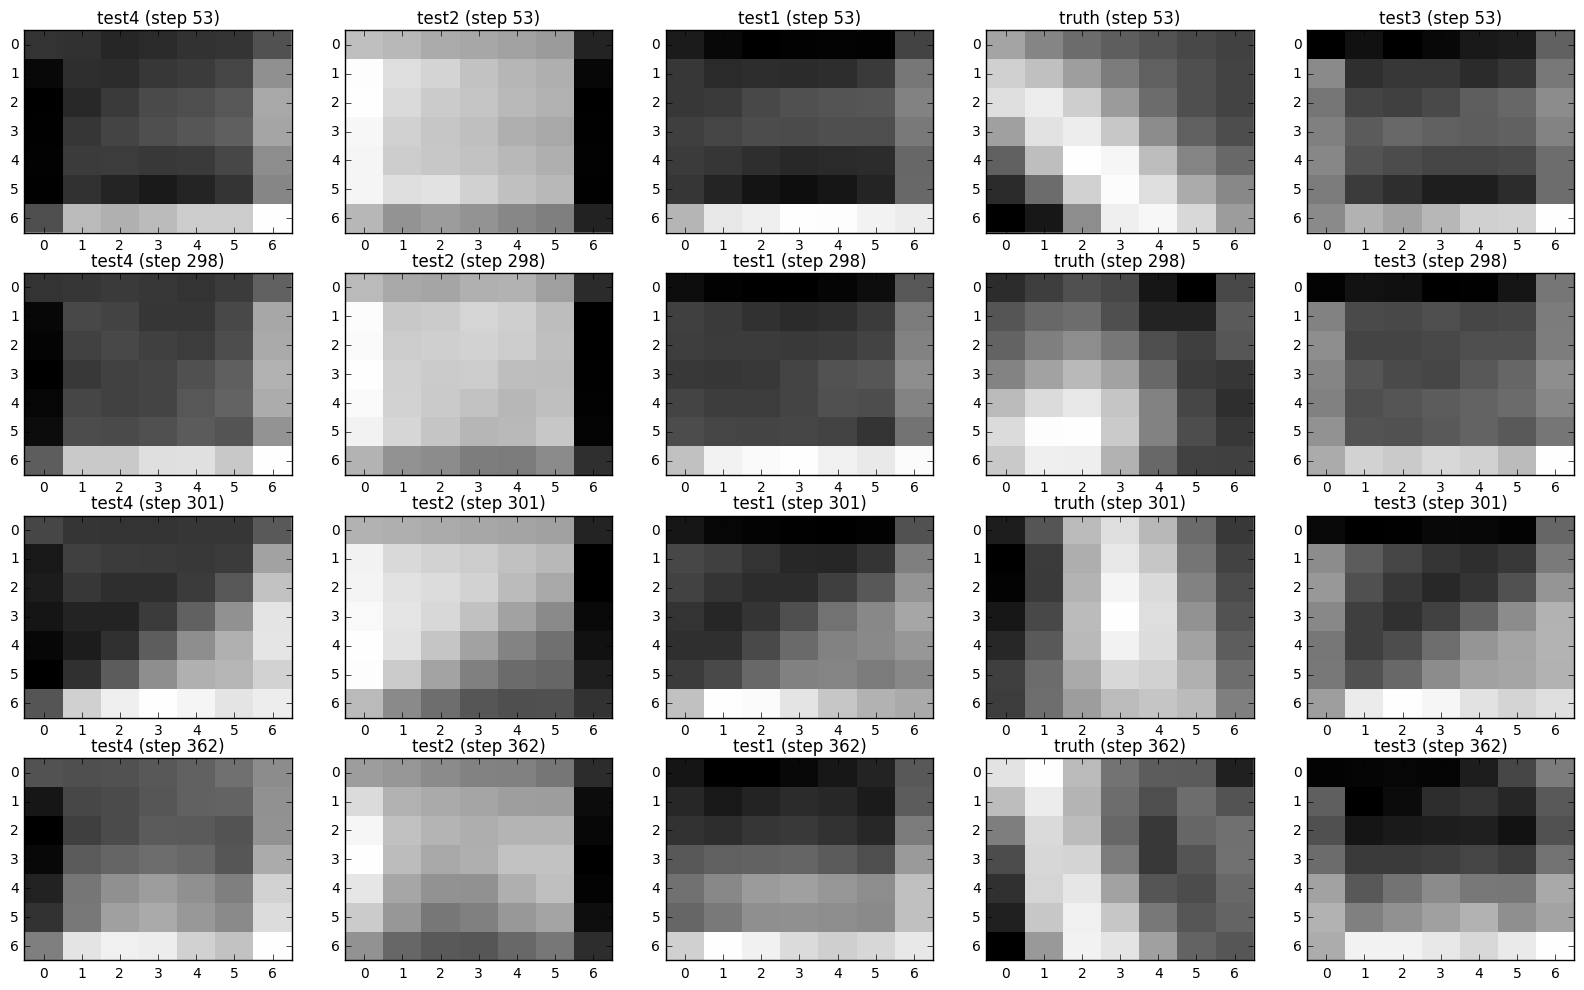

In [168]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (20, 12)

def image_grid(images):    
    f, ax = plt.subplots(4, 5)

    for i in range(4):
        step = us_th30_test[i][0]
        imgs = us_th30_test[i][1]
        keys = list(imgs.keys())

        for j in range(5):
            ax[i][j].set_title('{} (step {})'.format(keys[j], step))
            ax[i][j].imshow(imgs[keys[j]])
    
    plt.show()
    
image_grid(us_th30_test)